In [2]:
%cd ~/fur/
import numpy as np
import scipy.signal
from datetime import datetime
from scipy.optimize import minimize
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
shift_03_09_2020 = path_assistant.PathAssistant('shift_03_09_2020',      
    ignore_files=["RefCurve_2020-03-10_0_111937_test.Wfm.bin"])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift_03_09_2020.get_waveforms_dir()
results_dir = shift_03_09_2020.get_results_dir()


/home/ilobach/fur


In [4]:
t1 = datetime(2020, 3, 9, 19, 8, 0)
t2 = datetime(2020, 3, 9, 19, 42, 0)

In [5]:
wf_paths = [p for p in shift_03_09_2020.get_waveform_paths() if
            (t1 < shift_03_09_2020.get_datetime(os.path.basename(p)) < t2)]
n_files = len(wf_paths)

In [6]:
n_files

44

In [7]:
res_df = pd.DataFrame(columns=["waveform_file","ch2_amplitude","var_of_ch1_amplitude", "noise_var"], index=np.arange(n_files))
res_df["waveform_file"] = [os.path.basename(p) for p in wf_paths]

Started working on the file  RefCurve_2020-03-09_11_190827.Wfm.bin (1/44)


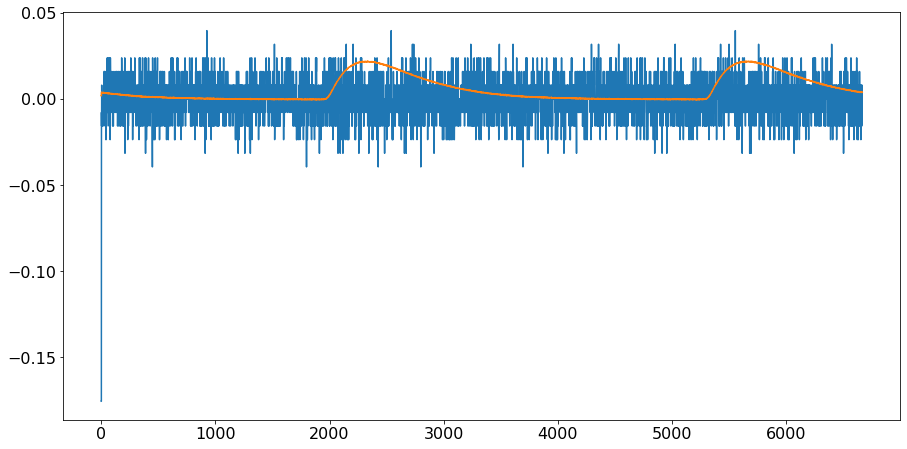

period = 3332.4479


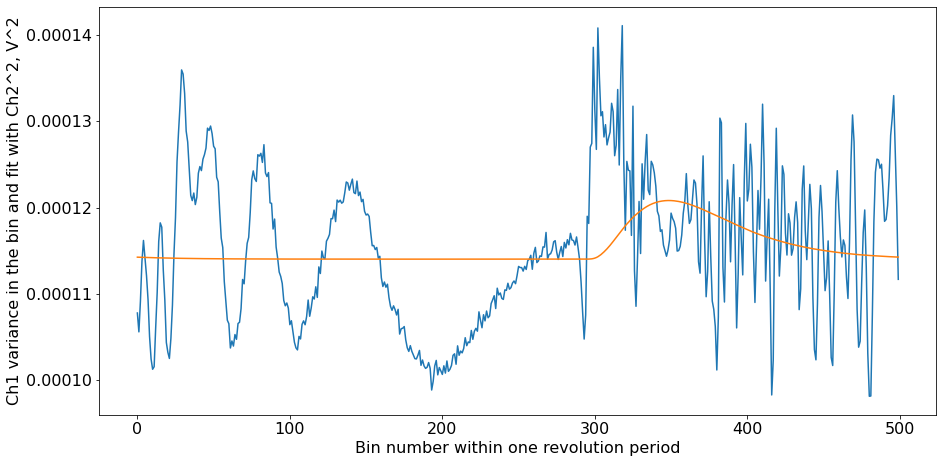

results = ch2_amplitude               2.19497
var_of_ch1_amplitude    6.78954e-06
noise_var               0.000114025
Name: 0, dtype: object
Finished working on  RefCurve_2020-03-09_11_190827.Wfm.bin (1/44)
Started working on the file  RefCurve_2020-03-09_12_190831.Wfm.bin (2/44)


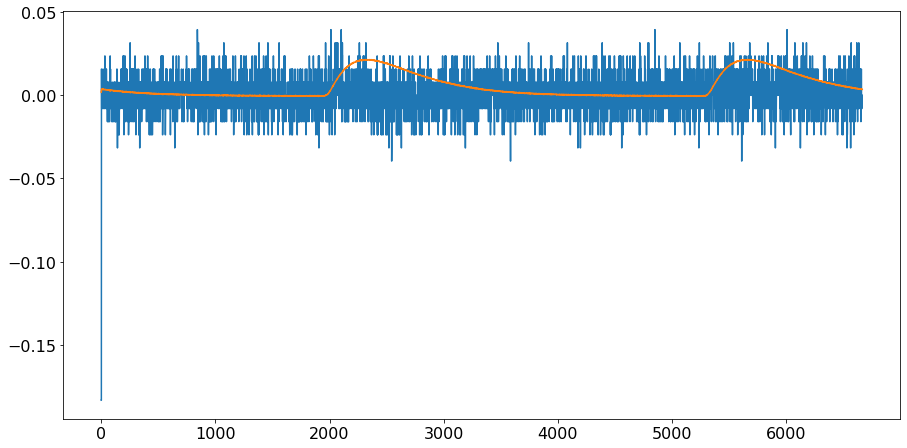

period = 3332.4478


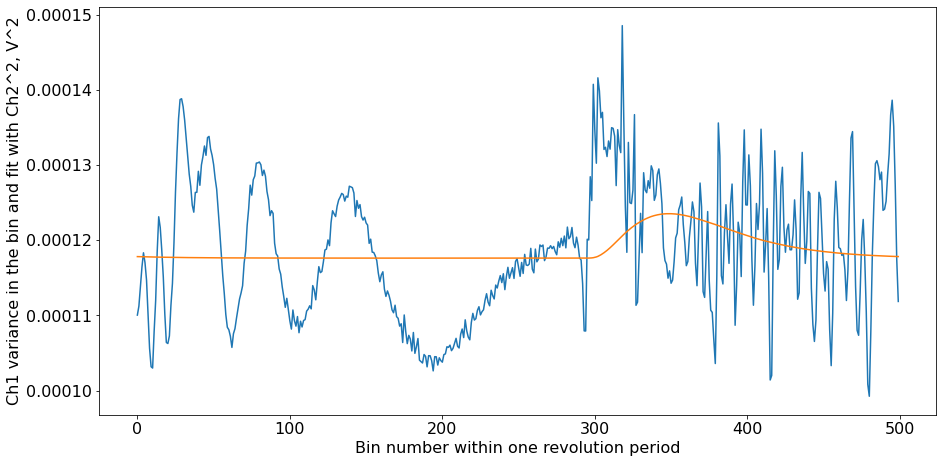

results = ch2_amplitude               2.17144
var_of_ch1_amplitude    5.91704e-06
noise_var               0.000117627
Name: 1, dtype: object
Finished working on  RefCurve_2020-03-09_12_190831.Wfm.bin (2/44)
Started working on the file  RefCurve_2020-03-09_13_190839.Wfm.bin (3/44)


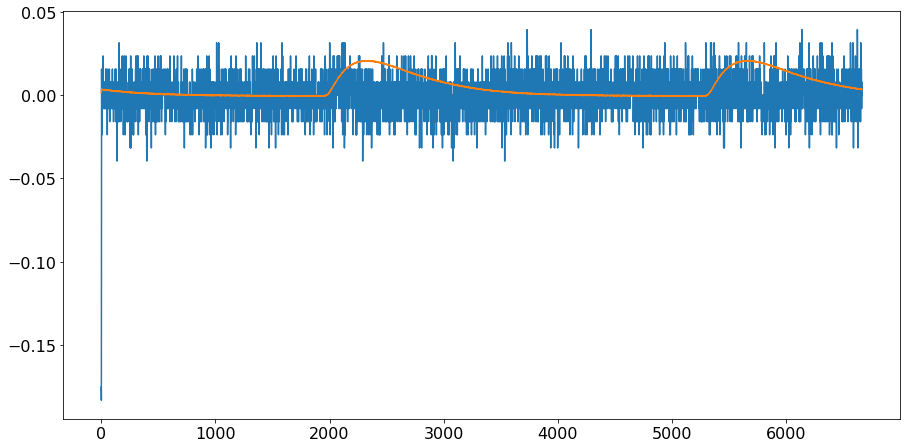

period = 3332.4478


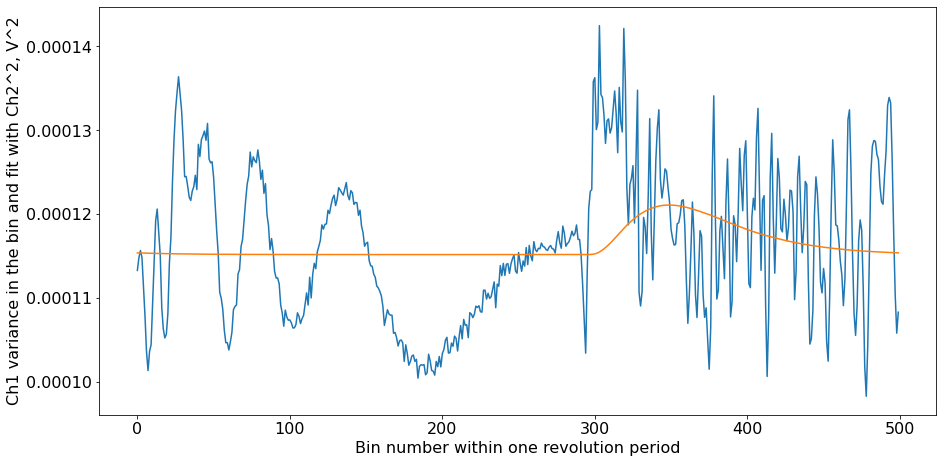

results = ch2_amplitude               2.10987
var_of_ch1_amplitude    5.90358e-06
noise_var               0.000115206
Name: 2, dtype: object
Finished working on  RefCurve_2020-03-09_13_190839.Wfm.bin (3/44)
Started working on the file  RefCurve_2020-03-09_14_190857.Wfm.bin (4/44)


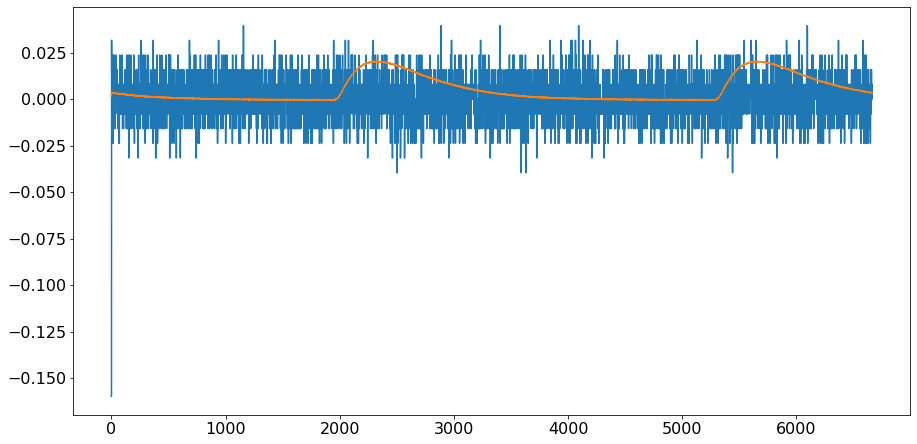

period = 3332.4478


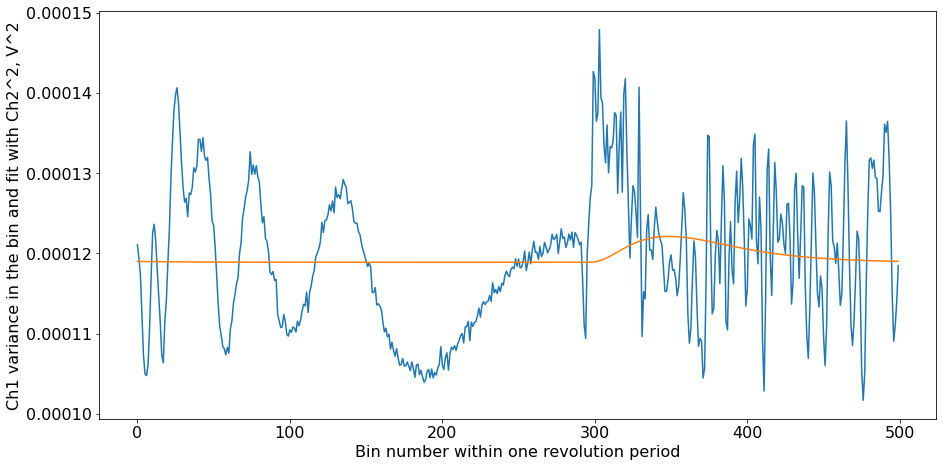

results = ch2_amplitude               2.05999
var_of_ch1_amplitude    3.22986e-06
noise_var               0.000118896
Name: 3, dtype: object
Finished working on  RefCurve_2020-03-09_14_190857.Wfm.bin (4/44)
Started working on the file  RefCurve_2020-03-09_15_190911.Wfm.bin (5/44)


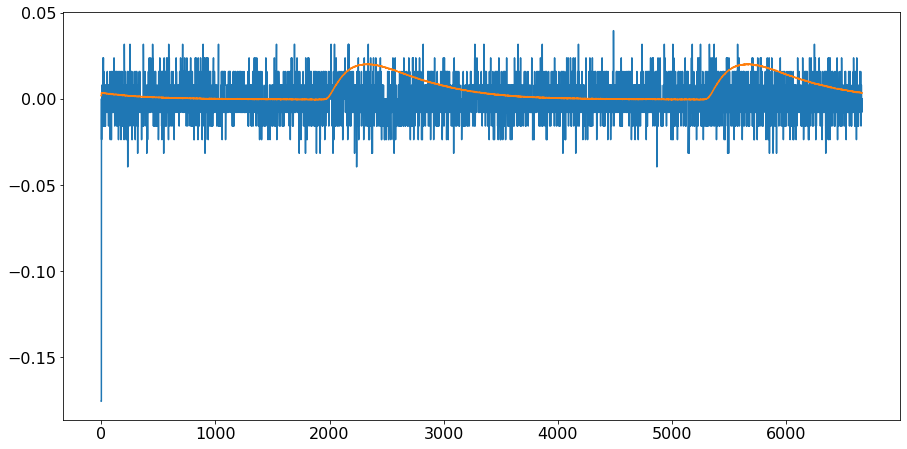

period = 3332.4477


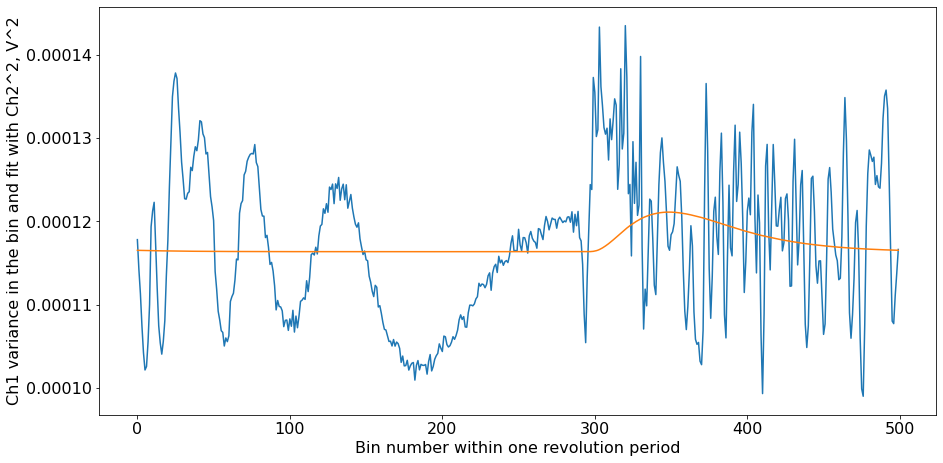

results = ch2_amplitude               2.03915
var_of_ch1_amplitude     4.7545e-06
noise_var               0.000116368
Name: 4, dtype: object
Finished working on  RefCurve_2020-03-09_15_190911.Wfm.bin (5/44)
Started working on the file  RefCurve_2020-03-09_16_190919.Wfm.bin (6/44)


In [8]:
for i,p in enumerate(wf_paths):
    status = os.path.basename(p)+" ({}/{})".format(i+1,n_files)
    print("Started working on the file ", status)
    try:
        ch = read_waveform(p, one_channel=True)
        period = get_period(ch)
        int_period = int(period)
        ch1 = ch[:-int_period]-ch[int_period:]
        ch2 = ch[:-int_period]+ch[int_period:]
        plt.plot(ch1[:3333*2])
        plt.plot(ch2[:3333*2]/100)
        plt.show()
        print("period = {:.4f}".format(period))
        res_df.iloc[i,1:] =\
            get_fluctiation_and_noise_var(ch1, ch2, period, n_bins=500, show_plots=True)
        print("results = {}".format(res_df.iloc[i,1:]))
    except Exception as e:
        print("Exception happened: ", e)
    print("Finished working on ", status)

In [8]:
res_df["waveform_file"] = res_df["waveform_file"].astype('str')
for i in range(1,4):
    res_df.iloc[:,i] = res_df.iloc[:,i].astype(np.float32)

In [9]:
res_df.to_csv(results_dir.fi("res_df_with_comb_FLAT_03_09_2020.csv"))

In [8]:
res_df = pd.read_csv(results_dir.fi("res_df_with_comb_FLAT_03_09_2020.csv"))

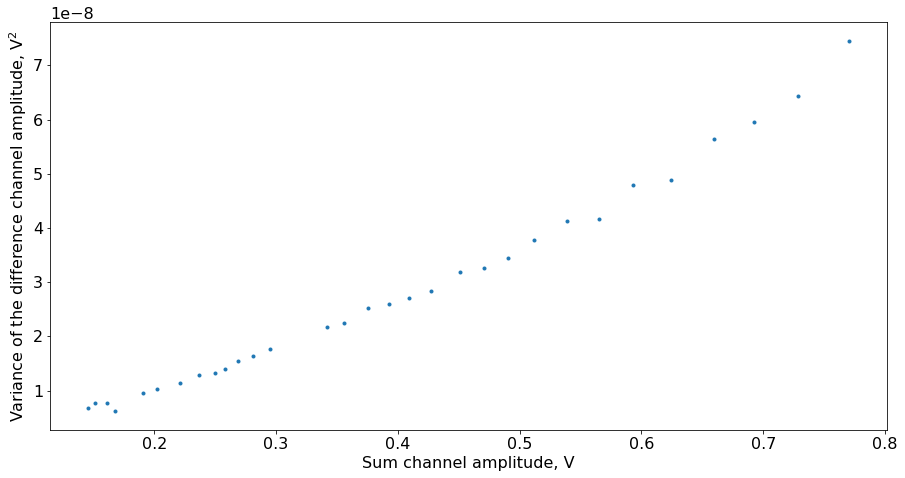

In [9]:
plt.plot(res_df["ch2_amplitude"],res_df["var_of_ch1_amplitude"] ,'.')
plt.xlabel("Sum channel amplitude, V")
plt.ylabel("Variance of the difference channel amplitude, V$^2$")
plt.show()

In [10]:
alpha = 1.6e-19/2e-12*np.sqrt(2)/4
alpha

2.8284271247461904e-08

In [11]:
reg = linear_model.LinearRegression(fit_intercept=False)
x1 = np.insert(res_df["ch2_amplitude"].values,0,0)
x2 = x1**2
y = np.insert(res_df["var_of_ch1_amplitude"].values,0,0)-alpha*x1
reg.fit(x2.reshape((len(x2), 1)), y)
a = reg.coef_[0]
Mf = np.sqrt(2)/(4*a)
Mf

4078202.1374774496

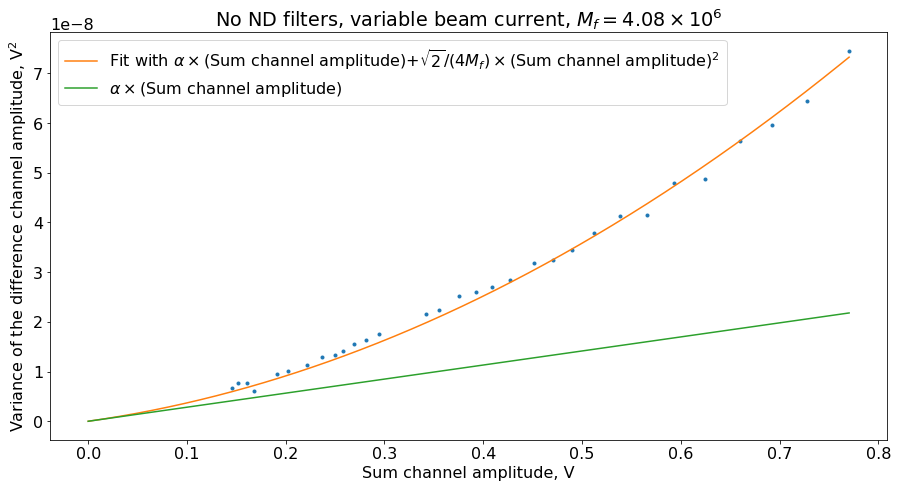

In [12]:
plt.plot(res_df["ch2_amplitude"],res_df["var_of_ch1_amplitude"] ,'.')
x_f = np.linspace(0,max(x1),1000)
plt.plot(x_f, alpha*x_f+a*x_f**2, label=r"Fit with $\alpha\times$(Sum channel amplitude)+$\sqrt{2}/(4M_f)\times$(Sum channel amplitude)$^2$")
plt.plot(x_f, alpha*x_f, label=r"$\alpha\times$(Sum channel amplitude)")
plt.xlabel("Sum channel amplitude, V")
plt.ylabel("Variance of the difference channel amplitude, V$^2$")
plt.title(r"No ND filters, variable beam current, $M_f=4.08\times 10^6$")
plt.legend()
plt.savefig(results_dir.fi("no_nd_filters_variable_beam_current.pdf"), bbox_inches='tight')
plt.show()

$\alpha=\frac{\sqrt{2}e}{4 C_f}$,
it is the predicted slope for the quantum Poisson contribution. - This estimation doesn't take into account attenuation and dispersion in the cable yet. When they are taken into account the agreement might get even better.
$M_f$ is the numer of coherent modes, according to the least squares fit.

$M_f = 4.1\times 10^6$

In [13]:
varN = 1/alpha**2*4*res_df["var_of_ch1_amplitude"].values
N = 1/alpha/np.sqrt(2)*res_df["ch2_amplitude"].values
plt.plot(N,varN,'.')
plt.show()